## 4.3 Downscaling Validation

After employing a method of statistical downscaling, such as DBCCA, it is important to perform some health checks and validation on the downscaled output, just like one would for the raw model data during the preliminary stages of analysis. However, since the downscaled results will be used to inform the rest of the climate impact study, the tests for agreement between the downscaled historical data and the observations need be more stringent. Bias-correction and downscaling should bring historical GCM data to excellent agreement with observations for a similar time period, otherwise the chosen methods shouldn't be trusted to perform well for future, out-of-sample data.

In this notebook we will use some publicly available downscaled climate data from PCIC, downscaled using BCCAQv2, and the NRCAN ANUSPLIN observations used as the training data for downscaling. We will perform some statistical tests to assess the agreement between the downscaled data and observations for the historical period, as well as some tests of significance for the climate change signal. 

As mentioned, the downscaled historical GCM data should be in near-perfect agreement with the observations for the reference period by construction. The most robust test would be to split the observations and historical simulations into training and validation periods. For example, we could calibrate our downscaling method using observations and historical simulation years from 1950-1980, apply this trained method to historical GCM simulations for 1981-2011, and then assess agreement with observations for 1981-2011. 

In their downscaling procedure, PCIC uses observations from 1950-2005. Unfortunately, this leaves only 12 years of *indepdendent* observations for which the quality of downscaling can be assessed, since the NRCAN observations are only available until the year 2017. Really, it only leaves 9 independent years, since the CMIP6 historical simulations end in the year 2014 (after that, the SSP scenarios begin, and they don't have observed radiative forcing boundary conditions like the historical simulations do). Despite these limitations, we will demonstrate the validation methods using observations and GCM data for 1950-2005, and also for the 2006-2017 period, to demonstrate the training-validation split process.


Before getting into the tests, let's import the necessary libraries and access the data files from the PAVICS server. For simplicity, we will analyze data for only a small spatial region around Montreal.

In [ ]:
import numpy as np
import xarray as xr
import dask
import scipy.stats as stats
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
spkws = dict(projection = ccrs.PlateCarree(), transform = ccrs.PlateCarree())

from siphon.catalog import TDSCatalog
from xclim.core.calendar import convert_calendar

# pysal.esda for spatial autocorrelation analysis
import esda 
import libpysal as lps

# URL for PAVICS' THREDDS server which hosts gridded observations and downscaled data
url_pavics = "https://pavics.ouranos.ca/twitcher/ows/proxy/thredds/catalog/datasets/"
url_obs = url_pavics + "gridded_obs/catalog.xml"
url_downscaled = url_pavics + "simulations/bias_adjusted/cmip6/pcic/CanDCS-U6/catalog.xml"

# centre of domain to analyze
lat_mtl = 45.5019
lon_mtl = -73.5674

# bounds of domain
lons = [lon_mtl - 1, lon_mtl + 1]
lats = [lat_mtl - 0.25, lat_mtl + 0.75]


In [ ]:
# Create Catalog object - this contains the info for the datasets in this directory
cat_obs = TDSCatalog(url_obs)

# open the obs dataset and load the tasmax data
cds_obs = cat_obs.datasets[0] 
obs_ds = xr.open_dataset(cds_obs.access_urls["OPENDAP"])

# select and spatial domain
obs_ds = obs_ds.sel(lat = slice(*lats[::-1]), lon = slice(*lons))

# reverse latitude dimension to match model - with latitudes increasing with the index
obs_ds = obs_ds.isel(lat=slice(None, None, -1))

# select time period and convert units
data_obs = obs_ds.tasmin - 273.15
data_obs_train = data_obs.sel(time = obs_ds.time.dt.year.isin(range(1950, 2006))).load() 
data_obs_test = data_obs.sel(time = obs_ds.time.dt.year.isin(range(2006, 2018))).load() 


In [ ]:
# same procedure for accessing model data
cat_sds = TDSCatalog(url_downscaled)

# open the gcm dataset and load the tasmax data
opendap_urls = [cat_sds.datasets[i].access_urls["OPENDAP"] for i in range(len(cat_sds.datasets))]
datasets_canesm = list(filter(lambda x: 'CanESM' in x, opendap_urls))

url_gcm = datasets_canesm[0] 
print(url_gcm)
gcm_ds = xr.open_dataset(url_gcm)
gcm_ds = gcm_ds.sel(lat = slice(*lats), lon = slice(*lons))

data_gcm = gcm_ds.tasmin
data_gcm_train = gcm_ds.tasmin.sel(time = gcm_ds.time.dt.year.isin(range(1950, 2006))).load() 
data_gcm_test = gcm_ds.tasmin.sel(time = gcm_ds.time.dt.year.isin(range(2006, 2018))).load() 

In [4]:
# convert obs calendar to match model
data_obs_train = convert_calendar(data_obs_train, 'noleap')
data_obs_test = convert_calendar(data_obs_test, 'noleap')

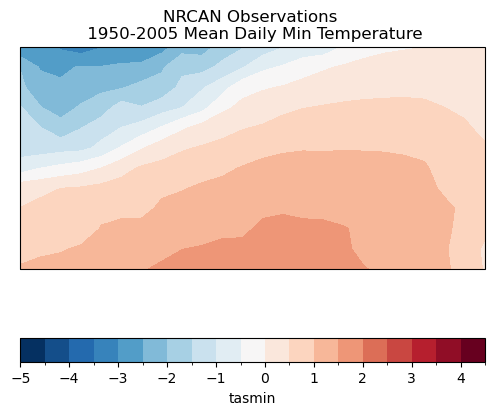

In [5]:
# plot the training sample long term means, just to compare quickly
data_mean_obs_train = data_obs_train.mean('time') 

fig, ax = plt.subplots(subplot_kw = spkws, figsize = (6,6))
data_mean_obs_train.plot.contourf(ax = ax, levels = np.arange(-5, 5, 0.5),
                                   cbar_kwargs = dict(orientation='horizontal', extendrect = True))
ax.add_feature(cfeature.LAKES, edgecolor = 'k', facecolor = 'none', zorder = 2)
ax.set_title("NRCAN Observations \n 1950-2005 Mean Daily Min Temperature")
plt.show()

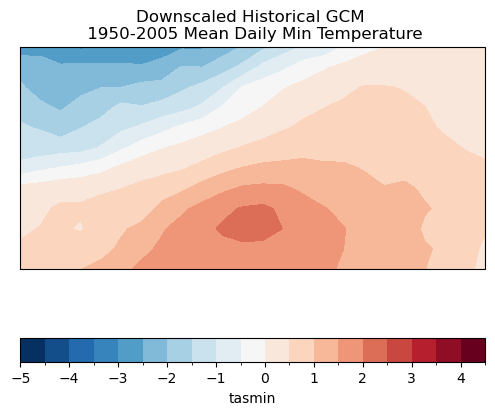

In [6]:
data_mean_gcm_train = data_gcm_train.mean('time') 

fig, ax = plt.subplots(subplot_kw = spkws, figsize = (6,6))
data_mean_gcm_train.plot.contourf(ax = ax, levels = np.arange(-5, 5, 0.5),
                                    cbar_kwargs = dict(orientation='horizontal', extendrect = True))
ax.add_feature(cfeature.LAKES, edgecolor = 'k', facecolor = 'none', zorder = 2)
ax.set_title("Downscaled Historical GCM \n 1950-2005 Mean Daily Min Temperature")
plt.show()

### 4.3.1 Distribution

The first test we will perform is one which tests that the probability distribution of the downscaled historical data is consistent with that of the observations. The most appropriate statistical test for this purpose is the **two sample Kolmogorov-Smirnov test**, often shortened to the [KS test](https://en.wikipedia.org/wiki/Kolmogorov%E2%80%93Smirnov_test). This is a nonparametric test, so we don't need to make any assumptions of Gaussian statistics, like one does with the Student's $t$-test, for example.

The null hypothesis of the KS test is that the two sets of data being compared are generated from the same underlying probability distribution. For our purpose, we *want* the two distributions to be indistinguishable, so if we can reject the null hypothesis, this means the bias-correction has not done it's job well. The Scipy routine `ks_2samp` implements this test in Python, and returns both the test statistic and the associated p-value (which is what we're more interested in). Let's run this test in the next notebook cell

In [9]:
# define a function which returns only the p-value, not the test statistic
get_ks_pval = lambda x,y: stats.ks_2samp(x, y).pvalue

# perform the test at each grid cell
ks_pvals_train = xr.apply_ufunc(get_ks_pval, 
                                # coordinate values are slightly mismatched, interp gcm to obs grid
                                data_gcm_train.interp(lat = data_obs_train.lat, 
                                                      lon = data_obs_train.lon),
                                data_obs_train,
                                input_core_dims = [['time'], ['time']], 
                                vectorize = True)

ks_pvals_test = xr.apply_ufunc(get_ks_pval, 
                               data_gcm_test.interp(lat = data_obs_test.lat, 
                                                    lon = data_obs_test.lon), 
                               data_obs_test,
                               input_core_dims = [['time'], ['time']], 
                               vectorize = True)

# mask where data is missing (if any)
ks_pvals_train = ks_pvals_train.where(~np.isnan(data_obs_train.isel(time=0)))
ks_pvals_test = ks_pvals_test.where(~np.isnan(data_obs_test.isel(time=0)))

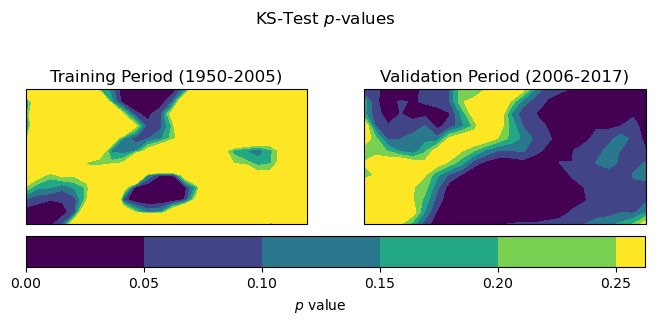

In [11]:
# plot
fig, axes = plt.subplots(ncols = 2, subplot_kw = spkws, figsize = (8,3))
fig.suptitle(r"KS-Test $p$-values")

p1 = ks_pvals_train.plot.contourf(ax = axes[0], levels = np.arange(0, 0.3, 0.05), add_colorbar = False)
axes[0].set_title("Training Period (1950-2005)")

p2 = ks_pvals_test.plot.contourf(ax = axes[1], levels = np.arange(0, 0.3, 0.05), add_colorbar = False)
axes[1].set_title("Validation Period (2006-2017)")

fig.colorbar(p1, ax = axes.ravel().tolist(), label = r"$p$ value", 
             orientation='horizontal', extendrect = True,
             pad = 0.05)
for ax in axes:
    ax.add_feature(cfeature.LAKES, edgecolor = 'k', facecolor = 'none', zorder = 2)

plt.show()

For the training period p-values for the KS tests are mostly greater than the typical thresholds of 0.05 or 0.1 for rejecting the null hypothesis. This means for these locations we do not have sufficient evidence to say that the downscaled GCM data and the observations follow different probability distributions - which is good! This is not unexpected, since BCCAQv2 uses Quantile Delta Mapping for bias correction, and quantile mapping forces the distribution of the downscaled historical GCM data to match the observed distribution (like we saw in Section 4.2). However, it looks like there are some parts of the domain where the distributions are significantly different (according to the KS test), and even more regions in the validation period. This could be a sampling issue, because we're looking at only a short time period, but it may also indicate some issues with the downscaling method. Assessing results for multiple methods of downscaling would be necessary to get an idea of the performance of one method relative to others.

### 4.3.2 Spatial Autocorrelation
The KS-test assesses whether the distributions of the downscaled data at each location follows the same probability distribution as the observations. Passing this test not guarantee that the observed *joint distribution* of the data at different spatial points is preserved by the downscaling. In other words, we also need to assess if the *spatial autocorrelations* of the downscaled data agree with the observations. The statistic we will use to measure the spatial autocorrelation is called [Moran's I](https://en.wikipedia.org/wiki/Moran%27s_I). This statistic is calculated with the formula:

$$
I = \frac{N}{W} \frac{\sum_{i=1}^{N} \sum_{j=1}^{N} w_{ij} (x_{i} - \overline{x})(x_{j} - \overline{x}) } {\sum_{i=1}^{N}(x_{i} - \overline{x})^{2}}
$$

Where $x_{i}$ is the variable of interest $x$ at grid cell $i$, $N$ is the total number of grid cells, $w_{ij}$ are weights which describe the relative importance of variability at grid cell $i$ to the variability at grid cell $j$ - typically these weights are 1 for some $k$ nearest-neighbours and zero otherwise, or they can continuously decay with distance. We will use the $k = 8$ nearest neighbours (the 8 grid cells surrounding a given grid cell). $W$ is the sum of all weights $w_{ij}$. We'll use the Python library ``pysal.esda`` to calculate Moran's I.

Since this calculation is a bit slow running on a laptop, we'll only do it for the validation period, which is shorter. In practice, one should take the time to calculate this metric for both the training and validation periods (which would likely be much more feasible with better computational resources).

In [12]:
# construct a list of (lon, lat) tuples to use to construct the spatial weights
nlat = len(data_obs_train.lat)
nlon = len(data_obs_train.lon)
npts =  nlat * nlon

pts = []

for i in range(nlat):
    for j in range(nlon):
        pts += [(data_obs_train.lon[j], data_obs_train.lat[i])]
        

len(pts)

288

In [13]:
# construct the kNN weights (k=8)
k = 8
weights = lps.weights.KNN.from_array(pts, k)

In [14]:

moran_I = lambda x: esda.Moran(x, weights).I

# calculate Moran's I for each timestep for the validation period.
moran_obs_test = xr.apply_ufunc(moran_I, data_obs_test,
                                input_core_dims = [['lat','lon']], 
                                output_dtypes = [float],
                                vectorize = True)

In [17]:
moran_gcm_test = xr.apply_ufunc(moran_I, data_gcm_test,
                                input_core_dims = [['lat','lon']], 
                                output_dtypes = [float],
                                vectorize = True)

In [21]:
# calculate mean and stdev's over time
moran_obs_test_mean = moran_obs_test.mean('time')
moran_gcm_test_mean = moran_gcm_test.mean('time')
moran_obs_test_std = moran_obs_test.std('time')
moran_gcm_test_std = moran_gcm_test.std('time')

print("Obs Moran I: %.2f" % moran_obs_test_mean.values, "+/- %.2f" % moran_obs_test_std.values)
print("Downscaled GCM Moran I: %.2f" % moran_gcm_test_mean.values, "+/- %.2f" % moran_gcm_test_std.values)

Obs Moran I: 0.95 +/- 0.02
Downscaled GCM Moran I: 0.92 +/- 0.04


The Moran's I values for the observational data and the downscaled GCM data are consistent with each other, which is promising. The BCCA portion of the BCCAQv2 downscaling algorithm performs well at producing observed spatial structures in the downscaled data, because it constructs the downscaled data using observed spatial patterns.